In [389]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import importlib
import tools        # importe le module (si non importé)
importlib.reload(tools)

# ré-affecter les fonctions si tu avais utilisé `from tools import ...`
setInitialValues = tools.setInitialValues
CSC = tools.CSC
CDU = tools.CDU
CSC_l0 = tools.CSC_l0
CSC_l0_stable = tools.CSC_l0_stable

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True


In [390]:
FOLDER = "../../Immersion Hopital/497-main/GaitData"
COLUMN_NAMES = ['TOX', 'TAX', 'TAY', 'RAV', 'RAZ', 'RRY', 'LAV', 'LAZ', 'LRY']

def load_metadata(subject, trial):
    code = f"{subject}-{trial}"
    with open(os.path.join(FOLDER, code + ".json")) as f:
        return json.load(f)

def load_XSens(filename):
    signal = pd.read_csv(filename, delimiter="\t", skiprows=1, header=0)
    signal["PacketCounter"] = (signal["PacketCounter"] - signal["PacketCounter"][0]) / 100
    for axis in ["X","Y","Z"]:
        signal[f"FreeAcc_{axis}"] = signal[f"Acc_{axis}"] - np.mean(signal[f"Acc_{axis}"])
    return signal

def load_signal(subject, trial):
    code = f"{subject}-{trial}"
    base = os.path.join(FOLDER, code)
    signal_lb = load_XSens(base + "_lb.txt")
    signal_lf = load_XSens(base + "_lf.txt")
    signal_rf = load_XSens(base + "_rf.txt")
    t_max = min(len(signal_lb), len(signal_lf), len(signal_rf))
    signal_lb, signal_lf, signal_rf = signal_lb[:t_max], signal_lf[:t_max], signal_rf[:t_max]

    gyr_x = signal_lb['Gyr_X']
    angle_x_full = np.cumsum(gyr_x)/100
    a = np.median(angle_x_full[:len(angle_x_full)//2])
    z = np.median(angle_x_full[len(angle_x_full)//2:])
    angle_x_full = np.sign(z)*(angle_x_full - a)*180/abs(z)

    sig = {
        'Time': signal_lb["PacketCounter"],
        'TOX': angle_x_full,
        'TAX': signal_lb["Acc_X"],
        'TAY': signal_lb["Acc_Y"],
        'RAV': np.sqrt(signal_rf["FreeAcc_X"]**2 + signal_rf["FreeAcc_Y"]**2 + signal_rf["FreeAcc_Z"]**2),
        'RAZ': signal_rf["FreeAcc_Z"],
        'RRY': signal_rf["Gyr_Y"],
        'LAV': np.sqrt(signal_lf["FreeAcc_X"]**2 + signal_lf["FreeAcc_Y"]**2 + signal_lf["FreeAcc_Z"]**2),
        'LAZ': signal_lf["FreeAcc_Z"],
        'LRY': signal_lf["Gyr_Y"]
    }
    return pd.DataFrame(sig)

def show_plot_simple(signal, to_plot, sample_rate=100):
    n_samples = len(signal)
    tt = np.arange(n_samples)/sample_rate
    for dim_name in to_plot:
        plt.figure()
        plt.plot(tt, signal[dim_name])
        plt.xlabel("Time (s)")
        plt.ylabel("m/s²" if dim_name[1]=="A" else "deg/s")
        plt.title(dim_name)
        plt.show()


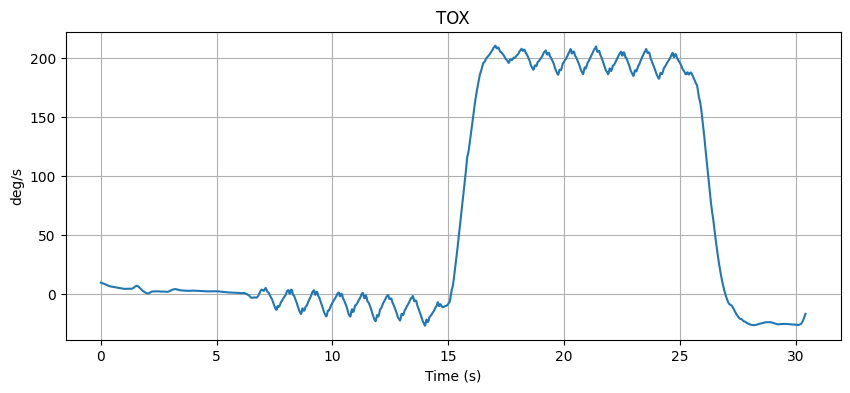

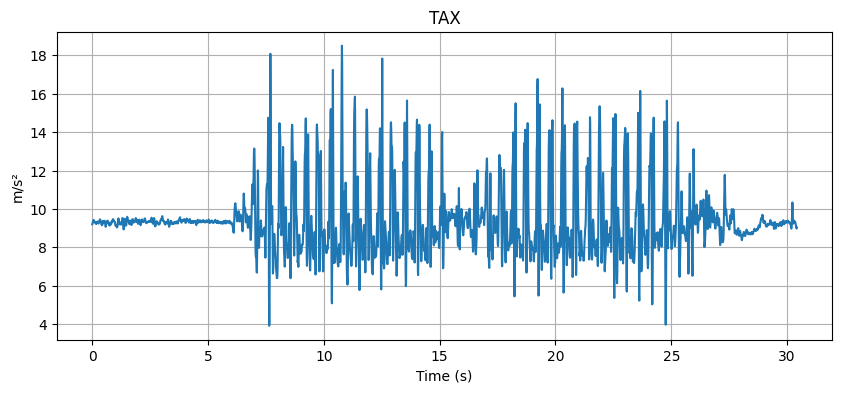

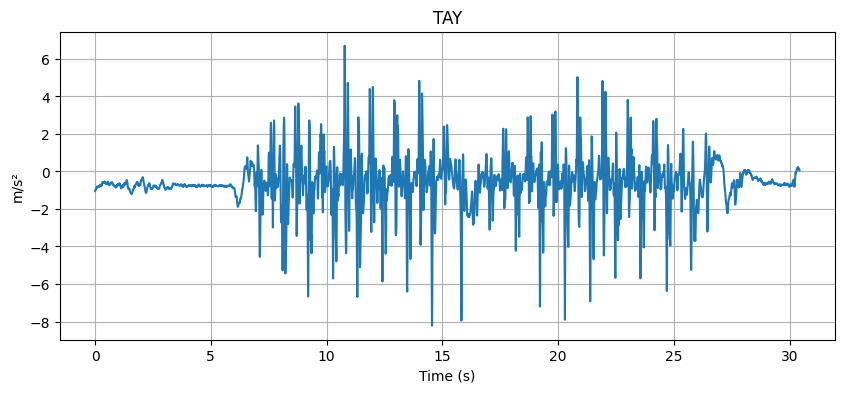

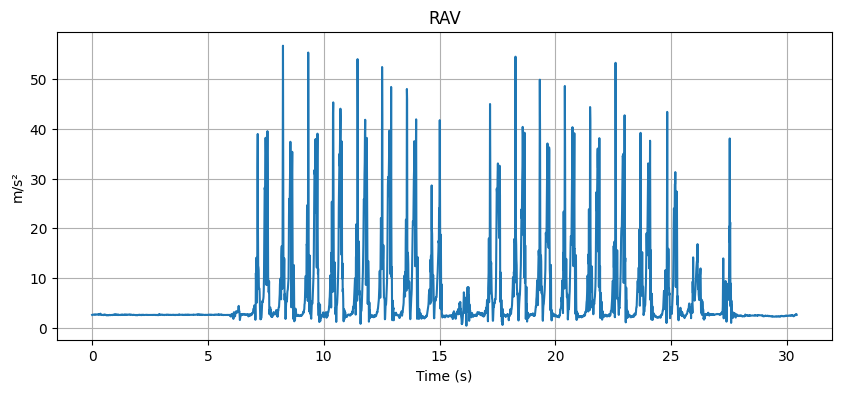

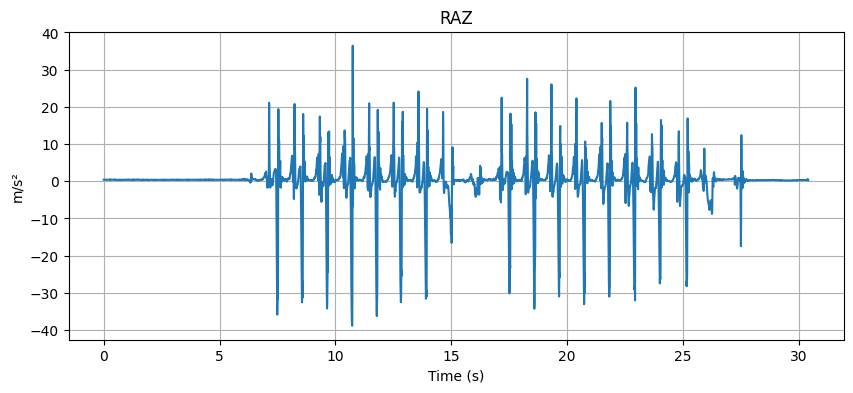

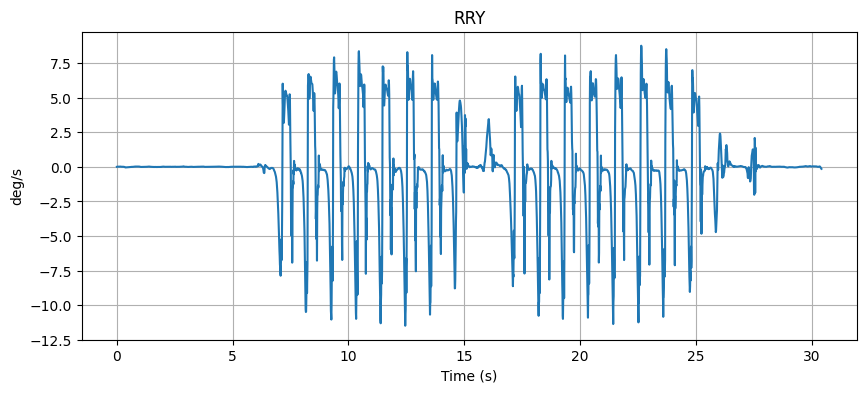

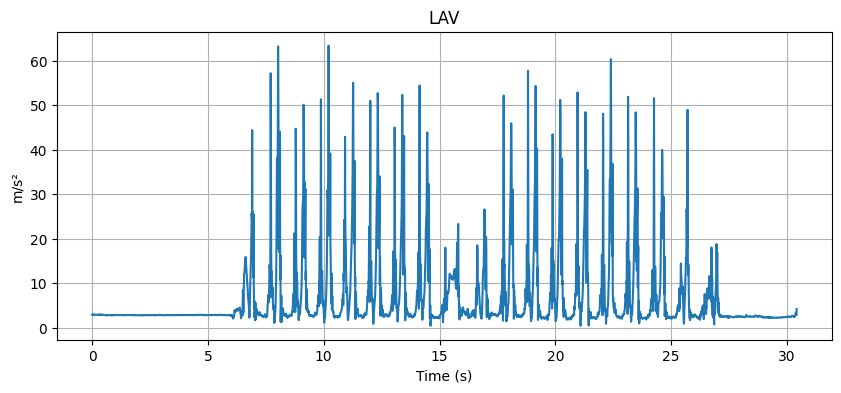

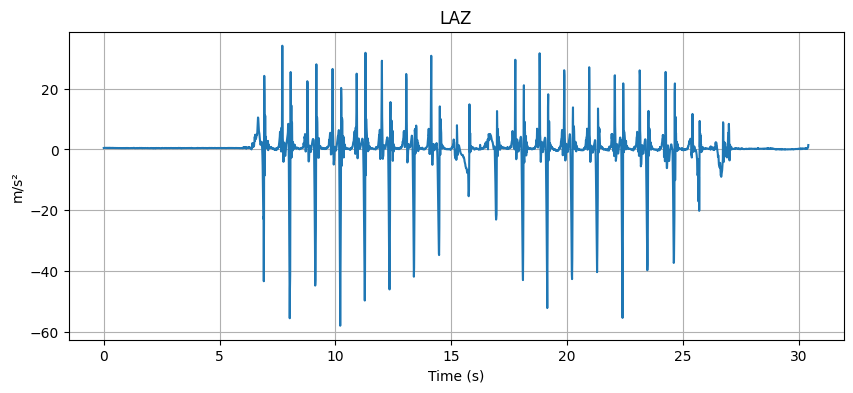

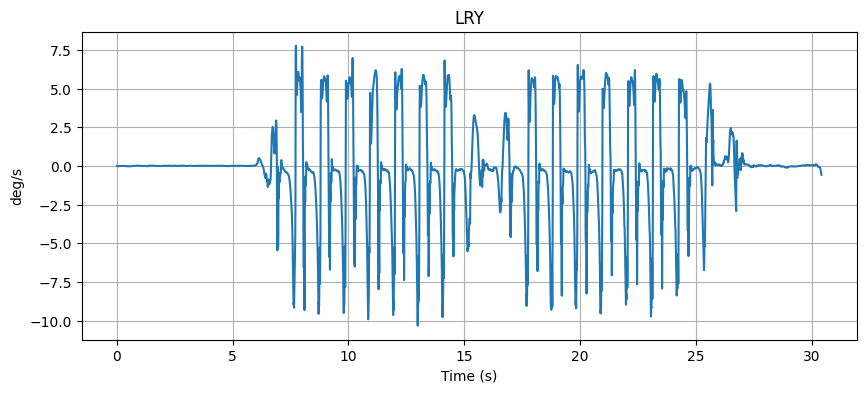

In [391]:
subject = 5
trial = 1
metadata = load_metadata(subject, trial)
signal = load_signal(subject, trial)

to_plot = ['TOX','TAX','TAY','RAV','RAZ','RRY','LAV','LAZ','LRY']
show_plot_simple(signal, to_plot)


In [392]:
def build_X(subjects, signal_names, trial=1):
    """
    Initialize X for multiple subjects and selected signals.

    Parameters:
    - subjects: list of int, the subject IDs to include
    - signal_names: list of str, the signal names to include (e.g., ['RAV','RAZ'])
    - trial: int, the trial number to use for each subject

    Returns:
    - X: torch.tensor of shape S x N x P
        S = number of subjects,
        N = number of time samples (truncated to the shortest signal),
        P = number of selected signals
    """
    import torch
    all_signals = []
    min_len = None

    for subj in subjects:
        sig_df = load_signal(subj, trial)
        sig = sig_df[signal_names].values  # shape: N_subject x P
        if min_len is None or len(sig) < min_len:
            min_len = len(sig)
        all_signals.append(sig)

    # truncate all signals to the same length
    truncated = [sig[:min_len] for sig in all_signals]

    # stack into a tensor of shape S x N x P
    X = torch.tensor(np.stack(truncated), dtype=torch.float32)
    return X


In [393]:
subjects = list(range(1, 11))  # 10 subjects
signal_names = ['RAV','RAZ','RRY']   # select only two signals
X = build_X(subjects, signal_names, trial=1)
print(X.shape)  # should output (10, N, 2)
X = X[:, 500:1300, :]

X = X - X.mean(dim=1, keepdim=True)
X = X / (X.std(dim=1, keepdim=True) + 1e-8)


torch.Size([10, 2389, 3])


In [394]:
S, N, P = X.shape
# paramètres pour PerCDL
K = 3   # nombre d'atomes
L = 70  # longueur des atomes
M = 10  # taille des paramètres de personnalisation

Phi, Z, A = setInitialValues(K, L, P, S, N, M)
print("Phi:", Phi.shape)
print("Z:", Z.shape)
print("A:", A.shape)


Phi: torch.Size([3, 70, 3])
Z: torch.Size([10, 3, 731])
A: torch.Size([10, 3, 10])


In [395]:
# Hyperparameters
n_iters = 200      # number of alternations
lambda_ = 0.1      # sparsity weight for CSC
step_size_z = 0.01 # gradient step for Z
step_size_phi = 0.01 # gradient step for Phi


for it in range(n_iters):
    if (it+1) % 10 == 0:
        print()
        print(f"Itérations {it+1}/{n_iters}...")
    # --- CSC step: update Z while keeping Phi fixed ---
    Z = CSC(X, Z, Phi, lambda_, step_size=step_size_z)
    # --- CDU step: update Phi while keeping Z fixed ---
    Phi = CDU(X, Z, Phi, step_size=step_size_phi)

print("Learned dictionary atoms")


Itérations 10/200...

Itérations 20/200...

Itérations 20/200...

Itérations 30/200...

Itérations 30/200...

Itérations 40/200...

Itérations 40/200...

Itérations 50/200...

Itérations 50/200...

Itérations 60/200...

Itérations 60/200...

Itérations 70/200...

Itérations 70/200...

Itérations 80/200...

Itérations 80/200...

Itérations 90/200...

Itérations 90/200...

Itérations 100/200...

Itérations 100/200...

Itérations 110/200...

Itérations 110/200...

Itérations 120/200...

Itérations 120/200...

Itérations 130/200...

Itérations 130/200...

Itérations 140/200...

Itérations 140/200...

Itérations 150/200...

Itérations 150/200...

Itérations 160/200...

Itérations 160/200...

Itérations 170/200...

Itérations 170/200...

Itérations 180/200...

Itérations 180/200...

Itérations 190/200...

Itérations 190/200...

Itérations 200/200...
Learned dictionary atoms

Itérations 200/200...
Learned dictionary atoms


# Visualisation des résultats

Cette cellule trace :
- les atomes appris (pour chaque canal),
- pour quelques sujets : signal original vs reconstruction et MSE,
- les cartes d'activations (Z) pour quelques sujets,
- les normes des atomes et checks NaN.

Affiche les graphiques inline. Ajuste `n_display` si tu veux plus/moins de sujets.

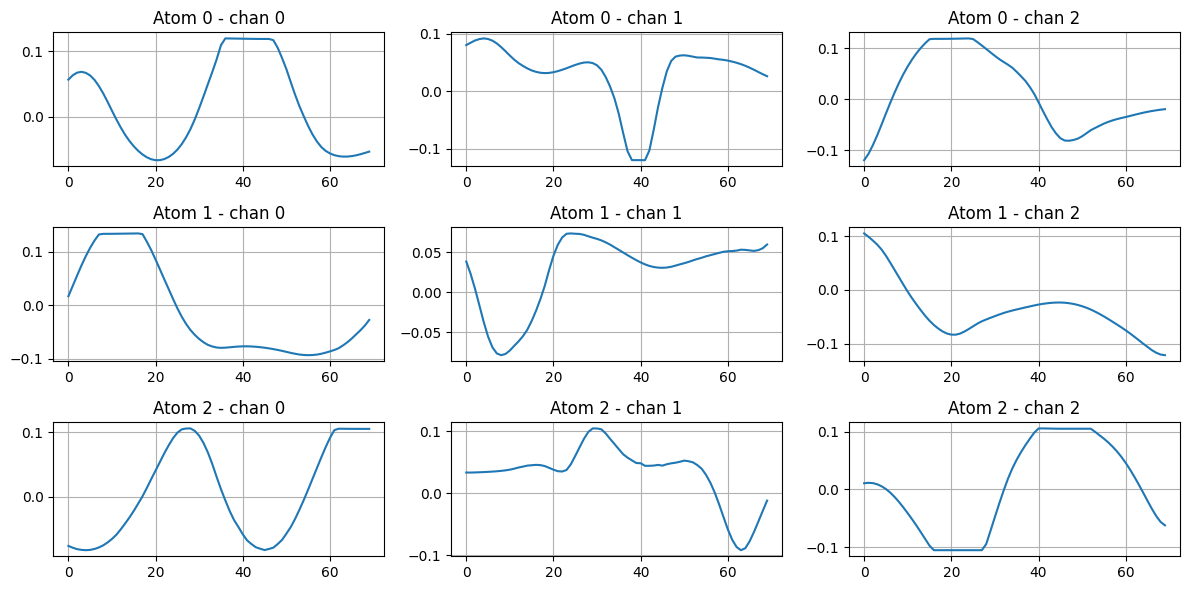

Subject 0 MSE: 5.272028e-01


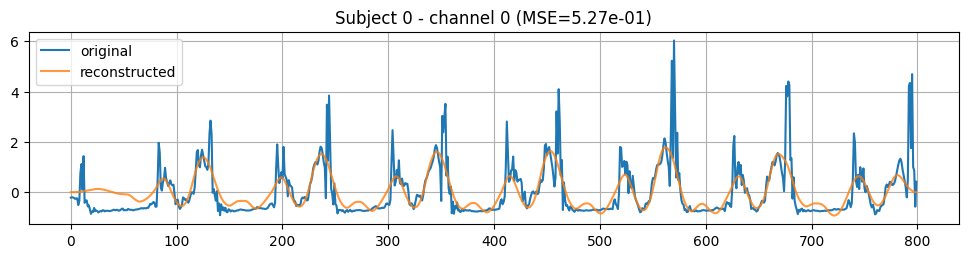

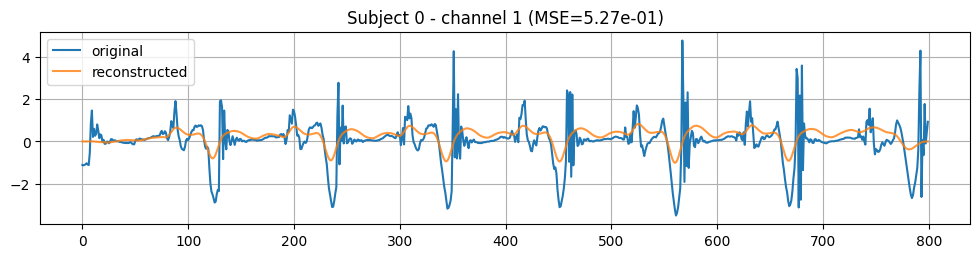

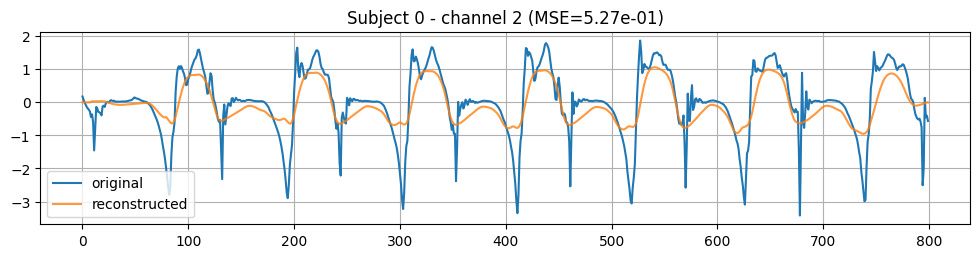

Subject 1 MSE: 5.497802e-01


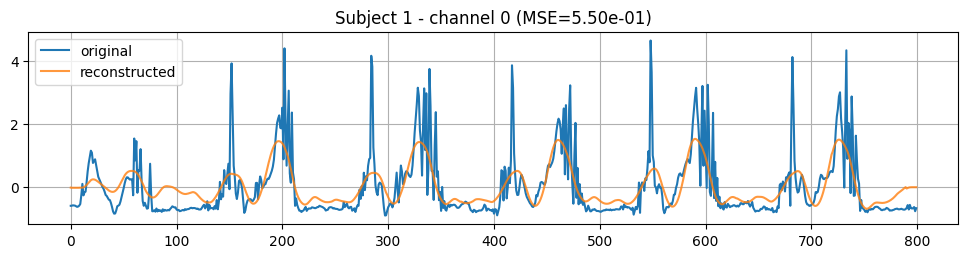

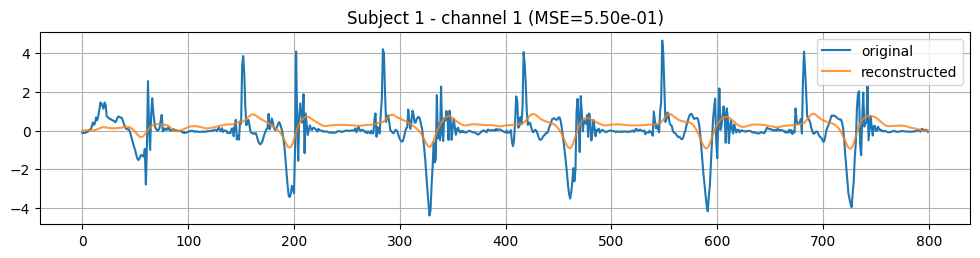

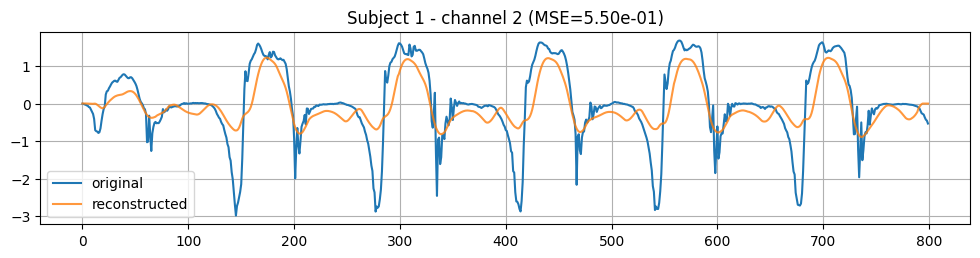

Subject 2 MSE: 5.105506e-01


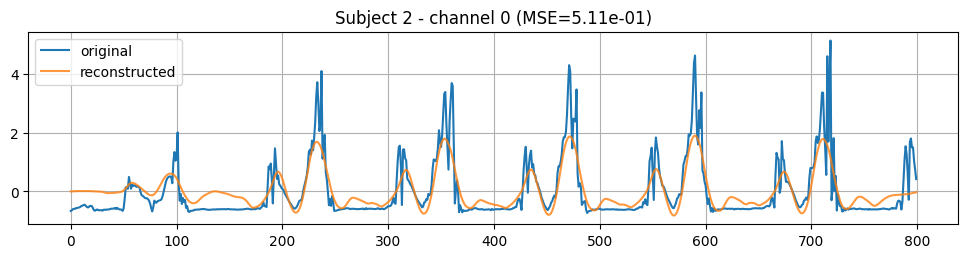

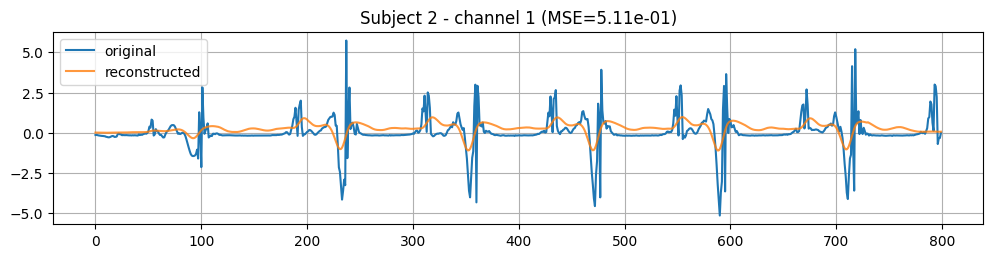

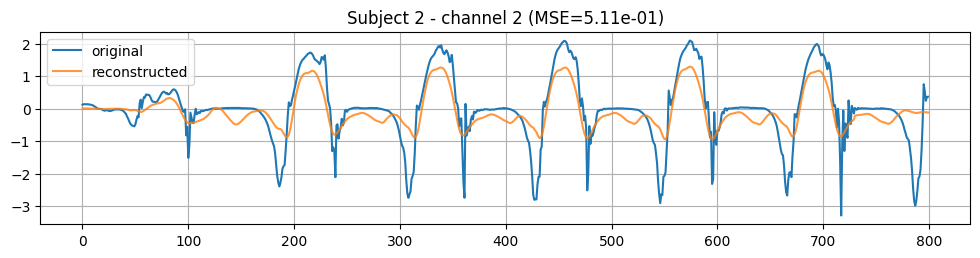

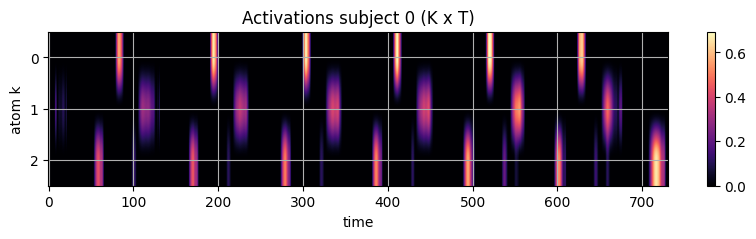

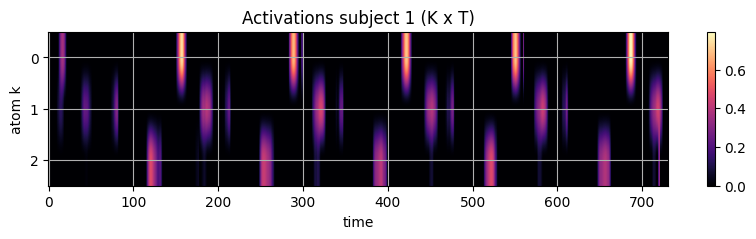

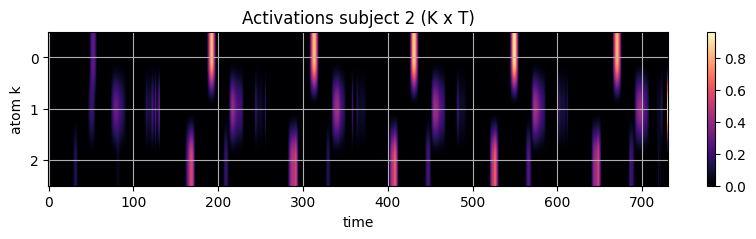

Atom norms: [1. 1. 1.]
MSE median: 5.179633e-01, mean: 5.217315e-01


In [396]:
# Visualisation détaillée
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# S'assurer que les variables existent
try:
    _ = Phi
    _ = Z
    _ = X
except NameError:
    raise RuntimeError("Les tenseurs Phi, Z, X doivent être définis avant d'exécuter cette cellule.")

# Copier sur CPU pour la visualisation
Phi_cpu = Phi.detach().cpu()
Z_cpu = Z.detach().cpu()
X_cpu = X.detach().cpu()

S, N, P = X_cpu.shape
K, L, P_phi = Phi_cpu.shape

# quick NaN check
if torch.isnan(Phi_cpu).any() or torch.isnan(Z_cpu).any() or torch.isnan(X_cpu).any():
    print("Attention : NaN détecté dans Phi / Z / X !")

# 1) Afficher les atomes (par canal)
fig, axs = plt.subplots(K, P, figsize=(4*P, 2*K))
for k in range(K):
    for p in range(P):
        if K == 1 and P == 1:
            ax = axs
        elif K == 1:
            ax = axs[p]
        elif P == 1:
            ax = axs[k]
        else:
            ax = axs[k, p]
        ax.plot(np.arange(L), Phi_cpu[k, :, p])
        ax.set_title(f'Atom {k} - chan {p}')
plt.tight_layout()
plt.show()

# 2) Reconstruction pour quelques sujets et calcul des MSE
n_display = min(3, S)
for s in range(n_display):
    z_s = Z_cpu[s].unsqueeze(0)  # 1 x K x T
    phi_conv = Phi_cpu.permute(0, 2, 1)  # K x P x L
    recon = F.conv_transpose1d(z_s, phi_conv, padding=0).squeeze(0).permute(1, 0)  # N x P
    recon = recon.numpy()
    x_s = X_cpu[s].numpy()

    if recon.shape != x_s.shape:
        print(f"Warning shape mismatch for subject {s}: recon {recon.shape} vs x {x_s.shape}")

    mse = ((x_s - recon) ** 2).mean()
    print(f'Subject {s} MSE: {mse:.6e}')

    for p in range(P):
        plt.figure(figsize=(12, 2.5))
        plt.plot(x_s[:, p], label='original')
        plt.plot(recon[:, p], label='reconstructed', alpha=0.8)
        plt.title(f'Subject {s} - channel {p} (MSE={mse:.2e})')
        plt.legend()
        plt.show()

# 3) Heatmap des activations Z (K x T) pour les mêmes sujets
for s in range(n_display):
    plt.figure(figsize=(10, 2))
    plt.imshow(Z_cpu[s].numpy(), aspect='auto', cmap='magma')
    plt.colorbar()
    plt.title(f'Activations subject {s} (K x T)')
    plt.xlabel('time')
    plt.ylabel('atom k')
    plt.show()

# 4) Normes des atomes
norms = Phi_cpu.view(K, -1).norm(p=2, dim=1).numpy()
print('Atom norms:', norms)

# 5) Statistiques globales
recons = []
mses = []
for s in range(S):
    z_s = Z_cpu[s].unsqueeze(0)
    recon = F.conv_transpose1d(z_s, Phi_cpu.permute(0, 2, 1), padding=0).squeeze(0).permute(1, 0).numpy()
    x_s = X_cpu[s].numpy()
    if recon.shape == x_s.shape:
        mses.append(((x_s - recon) ** 2).mean())

if len(mses) > 0:
    print(f"MSE median: {np.median(mses):.6e}, mean: {np.mean(mses):.6e}")
else:
    print("Pas de MSE calculée (shape mismatch partout).")


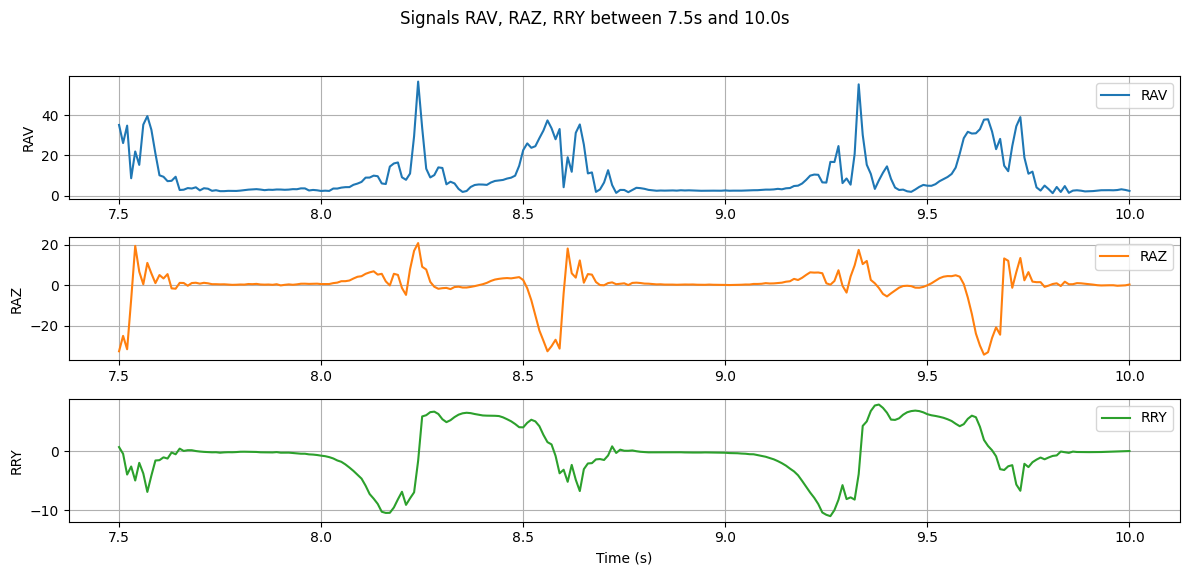

In [397]:
# Plot RAV, RAZ et RRY entre 7.5s et 10s
import matplotlib.pyplot as plt
import numpy as np

# Vérifier que 'signal' existe (DataFrame retournée par load_signal)
try:
    _ = signal
except NameError:
    raise RuntimeError("La variable 'signal' n'existe pas. Exécute d'abord la cellule qui charge la variable `signal` via `load_signal(subject, trial)`.")

# Sélection de l'intervalle temporel
t_min, t_max = 7.5, 10.0
mask = (signal['Time'] >= t_min) & (signal['Time'] <= t_max)
seg = signal.loc[mask]

if seg.empty:
    print(f"Aucune donnée entre {t_min}s et {t_max}s (vérifie l'échelle de la colonne 'Time').")
else:
    tt = seg['Time'].values

    plt.figure(figsize=(12, 6))

    # Trois sous-plots alignés
    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(tt, seg['RAV'].values, label='RAV')
    ax1.set_ylabel('RAV')
    ax1.legend()

    ax2 = plt.subplot(3, 1, 2, sharex=ax1)
    ax2.plot(tt, seg['RAZ'].values, label='RAZ', color='C1')
    ax2.set_ylabel('RAZ')
    ax2.legend()

    ax3 = plt.subplot(3, 1, 3, sharex=ax1)
    ax3.plot(tt, seg['RRY'].values, label='RRY', color='C2')
    ax3.set_ylabel('RRY')
    ax3.set_xlabel('Time (s)')
    ax3.legend()

    plt.suptitle(f"Signals RAV, RAZ, RRY between {t_min}s and {t_max}s")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()